In [1]:
!git clone https://github.com/khanhha/crack_segmentation.git

Cloning into 'crack_segmentation'...
remote: Enumerating objects: 625, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 625 (delta 48), reused 47 (delta 47), pack-reused 569
Receiving objects: 100% (625/625), 60.50 MiB | 2.24 MiB/s, done.
Resolving deltas: 100% (172/172), done.


In [2]:
%cd crack_segmentation

/Users/donghakim/__CRACK_UNET/crack_segmentation


In [3]:
!pip install albumentations==0.4.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 2.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 4.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=71d79a9aa9b50423ca466111e324c93795ec9978bd92e8ca1596b3adccf0e6eb
  Stored in directory: /Users/donghakim/Library/Caches/pip/wheels/84/ab/bb/5c36149e73c852c0fc8f278f457dd5b22df911cd65a542b16e
Successfully built albumentations


In [5]:
!pwd
import torch
from torch import nn
from unet.unet_transfer import UNet16, UNetResNet
from pathlib import Path
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
from torch.autograd import Variable
import shutil
from data_loader import ImgDataSetJoint, ImgDataSet
import os
import argparse
import tqdm
import numpy as np
import scipy.ndimage as ndimage
import albumentations as albu
# from albumentations.pytorch import ToTensor
import albumentations 
from albumentations.pytorch import ToTensorV2
import sys
import os
import numpy as np
from pathlib import Path
import cv2 as cv
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
from unet.unet_transfer import UNet16, input_size
import matplotlib.pyplot as plt
import argparse
from os.path import join
from PIL import Image
import gc
from utils import load_unet_vgg16, load_unet_resnet_101, load_unet_resnet_34
from tqdm import tqdm


/Users/donghakim/__CRACK_UNET/crack_segmentation


In [9]:

def evaluate_img(model, img):
    input_width, input_height = input_size[0], input_size[1]

    img_1 = cv.resize(img, (input_width, input_height), cv.INTER_AREA)
    X = train_tfms(Image.fromarray(img_1))
    X = Variable(X.unsqueeze(0)).cuda()  # [N, 1, H, W]

    mask = model(X)

    mask = F.sigmoid(mask[0, 0]).data.cpu().numpy()
    mask = cv.resize(mask, (img_width, img_height), cv.INTER_AREA)
    return mask

def evaluate_img_patch(model, img):
    input_width, input_height = input_size[0], input_size[1]

    img_height, img_width, img_channels = img.shape

    if img_width < input_width or img_height < input_height:
        return evaluate_img(model, img)

    stride_ratio = 0.1
    stride = int(input_width * stride_ratio)

    normalization_map = np.zeros((img_height, img_width), dtype=np.int16)

    patches = []
    patch_locs = []
    for y in range(0, img_height - input_height + 1, stride):
        for x in range(0, img_width - input_width + 1, stride):
            segment = img[y:y + input_height, x:x + input_width]
            normalization_map[y:y + input_height, x:x + input_width] += 1
            patches.append(segment)
            patch_locs.append((x, y))

    patches = np.array(patches)
    if len(patch_locs) <= 0:
        return None

    preds = []
    for i, patch in enumerate(patches):
        patch_n = train_tfms(Image.fromarray(patch))
        X = Variable(patch_n.unsqueeze(0)).cuda()  # [N, 1, H, W]
        masks_pred = model(X)
        mask = F.sigmoid(masks_pred[0, 0]).data.cpu().numpy()
        preds.append(mask)

    probability_map = np.zeros((img_height, img_width), dtype=float)
    for i, response in enumerate(preds):
        coords = patch_locs[i]
        probability_map[coords[1]:coords[1] + input_height, coords[0]:coords[0] + input_width] += response

    return probability_map

def disable_axis():
    plt.axis('off')
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_ticklabels([])
    plt.gca().axes.get_yaxis().set_ticklabels([])


In [13]:
model = load_unet_vgg16('model_unet_vgg_16_best.pt')

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
model

UNet16(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15)

In [ ]:
channel_means = [0.485, 0.456, 0.406]
channel_stds  = [0.229, 0.224, 0.225]


In [ ]:
train_tfms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(channel_means, channel_stds)])

In [110]:
# img_0 = Image.open('/content/drive/MyDrive/crack_in_large_context_04.jpeg')
img_0 = Image.open('/Volumes/GoogleDrive/공유 드라이브/SKTFLYAI/4.jpg')
img_0 = np.asarray(img_0)
img_0.shape

(832, 1243, 3)

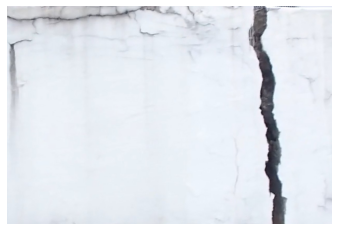

In [111]:
plt.imshow(img_0)
plt.axis('off')
plt.show()

In [112]:
img_0 = img_0[:,:,:3]
img_0.shape

(832, 1243, 3)

In [113]:
img_height, img_width, img_channels = img_0.shape


In [114]:
prob_map_full = evaluate_img(model, img_0)
img = (prob_map_full * 255).astype(np.uint8)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [115]:
img.shape

(832, 1243)

In [116]:
img

array([[22, 22, 16, ...,  7, 11, 11],
       [19, 19, 14, ...,  6,  8,  9],
       [13, 13,  9, ...,  2,  4,  4],
       ...,
       [ 6,  6,  4, ...,  2,  3,  3],
       [13, 13,  9, ...,  5,  7,  7],
       [17, 17, 12, ...,  7,  9, 10]], dtype=uint8)

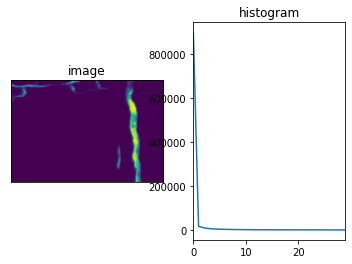

[898542  17453  10306   6802   5079   3995   3406   2931   2522   2233
   1991   1777   1591   1465   1421   1359   1246   1157   1159   1116
   1042   1001    945    898    882    835    765    766    757    781]


In [117]:
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('image')
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
hist, bin = np.histogram(img.ravel(),30,[0,29])
plt.xlim([0,29])
plt.plot(hist)
plt.title('histogram')

plt.show()
print(hist)

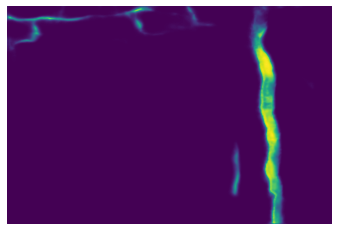

In [120]:
plt.imshow(img)
plt.axis('off')
plt.show()